In [1]:
import torch
from torch import nn
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch import optim
from torchvision.models import resnet18
import torch
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
torch.manual_seed(0)

## download CIFAR-10

In [2]:
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.models import resnet18


batch_size = 64
train_data = CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )
test_data = CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def validate(model, testloader, criterion, device):
    model.eval()
    print("Validation")
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100.0 * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [4]:
from torchvision.models import ResNet18_Weights

class ClassifierHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Linear(in_features=512, out_features=10, bias=True)
    
    def forward(self, x):
        return self.classifier(x)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

In [5]:
path = 'data/weights_1.pt'

model = resnet18().to(device)
model.fc = ClassifierHead().to(device)
model.load_state_dict(torch.load(path))
model.eval();

/tmp/ipykernel_448940/2698396606.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


In [6]:
validate(model, test_dataloader, criterion, device)

Validation


100%|██████████| 157/157 [00:01<00:00, 124.85it/s]


(1.1781141660205878, 82.37)

In [7]:
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1,2,0)))

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

In [8]:
from torchvision.transforms.v2 import GaussianNoise

class GHatDetermined(nn.Module):
    '''
    GHat model with fixed values epsilon[i], i = 1...N
    '''
    def __init__(self, model, sigma=0.1, n_samples=100):
        super().__init__()

        self.n_samples = n_samples
        self.noiser = GaussianNoise(mean=0, sigma=sigma)
        self.model = model.to(device)
        self.epsilons = [
            self.noiser(torch.zeros(3, 32, 32)).to(device)
            for _ in range(self.n_samples)
        ]
        self.softmax = nn.Softmax()

    def forward(self, x):
        probs = torch.zeros(1, 10).to(device)
        probs.requires_grad = True
        for i in range(self.n_samples):
            new_x = x + self.epsilons[i]
            probs = probs + self.softmax(self.model(new_x))
        probs /= self.n_samples
        return probs

class GHat:
    def __init__(self, model, sigma=0.1, n_samples=100):
        self.noiser = GaussianNoise(mean=0.0, sigma=sigma)
        self.n_samples = n_samples
        self.model = model.to(device)
        self.softmax = nn.Softmax()
    
    def forward(self, image):
        image = image.to(device)
        if len(image.shape) == 3:
            image = image.unsqueeze(dim=0)
        probs = torch.zeros(1, 10).to(device)
        for iteration in range(self.n_samples):
            probs += self.softmax(self.model(self.noiser(image)))
        probs /= self.n_samples
        return probs
    
    def __call__(self, image):
        return self.forward(image)

In [9]:
ghat = GHat(model, n_samples=100)

In [10]:
from torchvision.transforms.v2 import GaussianNoise

def random_attack(model, image, true_label, noiser=GaussianNoise(mean=0, sigma=0.05), n_tries=100):
    true_label = model(image.unsqueeze(dim=0).to(device)).argmax().item()
    for attempt in range(1, n_tries + 1):
        new_image = noiser(image)
        new_image = new_image.unsqueeze(dim=0).to(device)
        label = model(new_image).argmax().item()
        if label != true_label:
            new_image = new_image.squeeze(0).detach()
            return label, new_image, attempt

In [11]:
def fgsm_attack(model, image, true_label, epsilon=0.01):
    model.eval()
    
    if len(image.shape) == 3:
        image = image.unsqueeze(dim=0)
    image = image.to(device)
    image.requires_grad = True
    
    output = model(image)
    loss = criterion(model(image), torch.tensor([true_label]).to(device))
    model.zero_grad()
    loss.backward()
    
    image_grad = image.grad
    
    bad_image = image + epsilon * image_grad.sign()
    bad_image = torch.clamp(bad_image, 0, 1)

    label = model(bad_image).argmax().item()
    has_attack_worked = (label != true_label)
    
    bad_image = bad_image.squeeze(0).detach()
    
    return has_attack_worked, bad_image, label

In [12]:
def get_gradient_estimation(model, image, true_label, n_samples=10):
    if len(image.shape) == 3:
        image = image.unsqueeze(dim=0)
    image.requires_grad = True
    loss_fn = nn.NLLLoss()

    for _ in range(n_samples):
        gdet = GHatDetermined(model)
        log_prob = torch.log(gdet(image))
        loss = loss_fn(log_prob, torch.tensor([true_label]).to(device))
        loss.backward()
        model.zero_grad()
    grad_estimation = image.grad / n_samples
    return grad_estimation

In [13]:
def find_gradient_estimation_attack(
        model,
        model_to_attack,
        image,
        true_label,
        epsilon_mult=1,
        epsilon=0.04,
        n_samples=10,
        eps_limits = (10**(-6), 100)
    ):
    model.eval()

    image = image.to(device)
    gradient_estimation = get_gradient_estimation(model, image, true_label, n_samples).to(device)
    bad_image = image + epsilon * gradient_estimation.sign()
    bad_image = torch.clamp(bad_image, 0, 1)
    new_label = model_to_attack(bad_image).argmax().item()
    true_label = true_label.item()

    if epsilon_mult == 1:
        bad_image = bad_image.squeeze(0).detach()
        return new_label != true_label, bad_image, new_label, epsilon
    elif epsilon_mult > 1:
        while new_label == true_label and epsilon < eps_limits[1]:
            epsilon *= epsilon_mult
            bad_image = image + epsilon * gradient_estimation.sign()
            bad_image = torch.clamp(bad_image, 0, 1)
            new_label = model_to_attack(bad_image).argmax().item()
        bad_image = bad_image.squeeze(0).detach()
        return eps_limits[0] < epsilon < eps_limits[1],  bad_image, new_label, epsilon
    else:
        while new_label != true_label and eps_limits[0] < epsilon:
            epsilon *= epsilon_mult
            bad_image = image + epsilon * gradient_estimation.sign()
            bad_image = torch.clamp(bad_image, 0, 1)
            new_label = model_to_attack(bad_image).argmax().item()
        bad_image = image - epsilon * gradient_estimation.sign()
        bad_image = bad_image.squeeze(0).detach()
        return eps_limits[0] < epsilon < eps_limits[1], bad_image, new_label, epsilon

## Атакуем по-умному

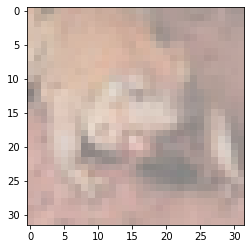

In [14]:
images_batch, labels_batch = next(iter(test_dataloader))
image = images_batch[5]
true_label = labels_batch[5].item()
imshow(image)

### Атакуем и строим зависимость

In [17]:
# ищем картинку с наим p_a-p_b
eps_dependence = [[], [], []]  # [[p_gap_1, p_gap_2, ...], [eps_1, eps_2, ...], [certified_radius_1, certified_radius_2, ...]]
eps_limits = (10**(-6), 10)
phi_inv = lambda x: torch.distributions.Normal(0, 1).icdf(torch.tensor(x))

cnt_success = 0
model_to_attack = GHat(model)
for image_batch, label_batch in test_dataloader:
    image_batch = image_batch.to(device)
    label_batch = label_batch.to(device)

    for image, label in zip(image_batch, label_batch):
        eps = 0.05
        imshow(image.cpu())
        p_sorted = (nn.Softmax()(model(image.unsqueeze(dim=0)))[0]).sort(descending=True)
        if p_sorted.indices[0].item() != label.item():
            continue
        p_a = p_sorted.values[0].item()  # a_class = p_sorted.indices[0].item()
        p_b = p_sorted.values[1].item()
        p_gap = p_a-p_b

        if p_gap > 0.9:
            continue
        
        is_successful, bad_image, label_predicted, _ = find_gradient_estimation_attack(model, model_to_attack, image, label, epsilon=eps)
        
        if is_successful: # class changed
            eps_mult = 0.5
        else: # same class
            eps_mult = 2

        is_successful, bad_image, label_predicted, eps = find_gradient_estimation_attack(model, model_to_attack, image, label, eps_mult, epsilon=eps)
        
        if is_successful:
            print(f'p_gap={round(p_gap, 5)}, p_a={round(p_a, 5)}, p_b={round(p_b, 5)}. eps={eps}. p_gap/eps={p_gap / eps}. {classes[label.item()]} -> {classes[label_predicted]}')
            eps_dependence[0].append(p_gap)
            eps_dependence[1].append(eps)
            eps_dependence[2].append(0.1 / 2 * (phi_inv(p_a) - phi_inv(p_b)).item())
            cnt_success +=1 
            if cnt_success > 10000:
                break
        else: 
            print(f'p_gap={round(p_gap, 5)}, BAD eps={eps}')
    with open('clever_attack.txt', 'w') as f:
        for vector in eps_dependence:
            line = ', '.join(map(str, vector))
            f.write(line + '\n')

p_gap=0.27448, BAD eps=7.62939453125e-07
p_gap=0.80935, BAD eps=7.62939453125e-07
p_gap=0.63897, p_a=0.78289, p_b=0.14392. eps=0.003125. p_gap/eps=204.4696283340454. horse -> horse
p_gap=0.47452, BAD eps=7.62939453125e-07
p_gap=0.43589, BAD eps=7.62939453125e-07
p_gap=0.81737, p_a=0.90869, p_b=0.09131. eps=0.003125. p_gap/eps=261.55993938446045. automobile -> automobile
p_gap=0.88259, BAD eps=7.62939453125e-07
p_gap=0.86568, p_a=0.93127, p_b=0.06559. eps=0.0015625. p_gap/eps=554.0328884124756. cat -> cat
p_gap=0.88339, p_a=0.92946, p_b=0.04607. eps=0.00625. p_gap/eps=141.34210348129272. bird -> bird
p_gap=0.59689, BAD eps=7.62939453125e-07
p_gap=0.63494, p_a=0.81745, p_b=0.18251. eps=0.00078125. p_gap/eps=812.7257347106934. frog -> frog
p_gap=0.5949, BAD eps=7.62939453125e-07
p_gap=0.49559, BAD eps=7.62939453125e-07
p_gap=0.69873, p_a=0.84936, p_b=0.15063. eps=0.00625. p_gap/eps=111.79670810699463. frog -> frog
p_gap=0.11589, BAD eps=7.62939453125e-07
p_gap=0.78156, p_a=0.89066, p_b=0.

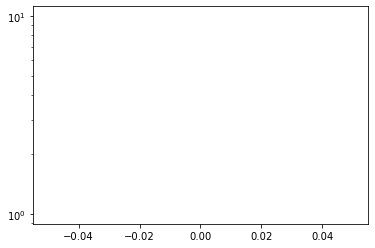

In [16]:
plt.scatter(eps_dependence[0], eps_dependence[1], s=5)
plt.yscale('log')